In [1]:
import xarray as xr
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.stats import linregress
from matplotlib.colors import LogNorm
import cmocean

settings = json.load(open('../plot_settings.json'))
plt.rcParams.update(settings)

In [2]:
path = '/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/simulation/sim_out/'
files = [os.path.join(path, f) for f in os.listdir(path) if 'MODIS_SST' in f]
files.sort()

ds = xr.concat([xr.open_dataset(f) for f in files], dim='time')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

BT1 = ds['BT'].isel(channel=0) - 273.15
BT2 = ds['BT'].isel(channel=1) - 273.15
BT3 = ds['BT'].isel(channel=2) - 273.15
BT5 = ds['BT'].isel(channel=3) - 273.15
BT6 = ds['BT'].isel(channel=4) - 273.15

skinT = ds['MODIS_skin_T'] - 273.15

nanmask = ~np.isnan(BT5) & ~np.isnan(skinT)
BT5 = BT5[nanmask]
skinT = skinT[nanmask]


ERROR 1: PROJ: proj_create_from_database: Open of /home/jomueller/micromamba/envs/mamba_josh/share/proj failed


RMSE = 0.4739294152989979 K
slope = 0.9673704862122282, intercept = 0.13785602780613715, r² = 0.9981478068713237


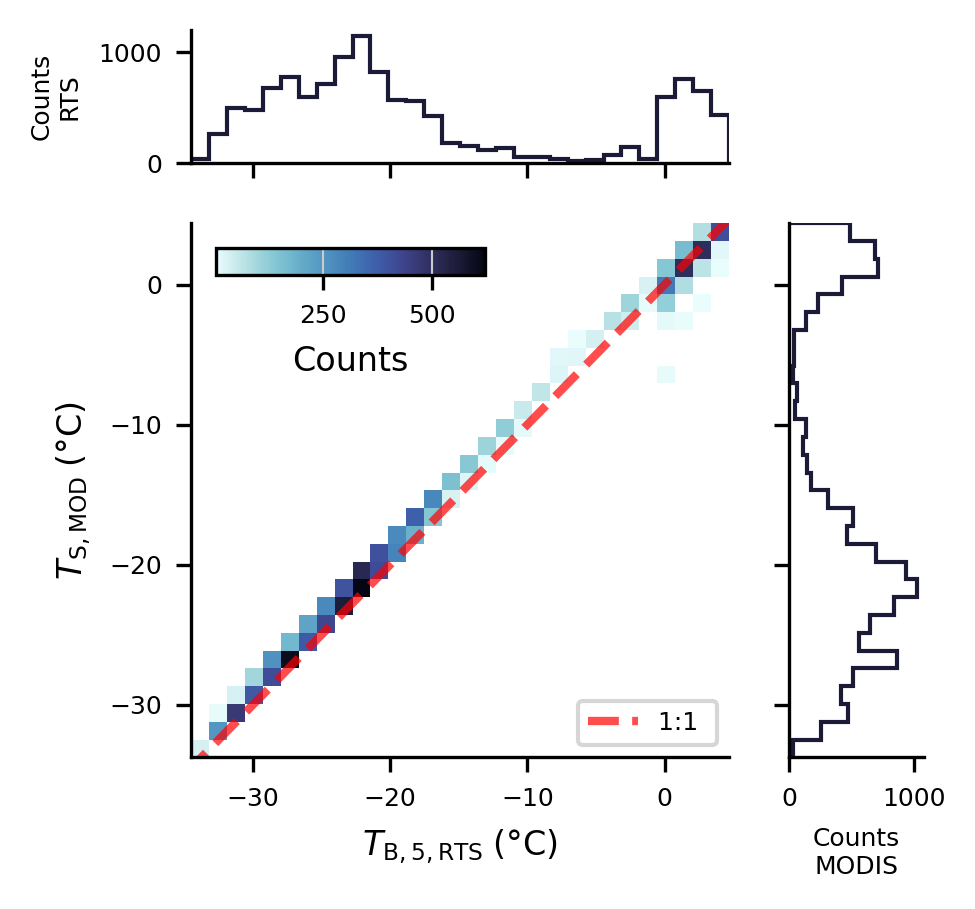

In [5]:
### first, plot all of them together

ylabel = r'$T_\mathrm{S,MOD}\;\mathrm{(°C)}$'
xlabel = r'$T_\mathrm{B,5,RTS}\;\mathrm{(°C)}$'

fig, ax = plt.subplots(1, 1, figsize=(3.15, 3.15))

y = skinT 
x = BT5 


dark2_colors = plt.get_cmap('Dark2')(np.linspace(0,1,4))

slope, intercept, r_value, p_value, std_err = linregress(x, y)


#ax.hist2d(x, y, bins=100, norm=LogNorm(), cmap='viridis')
ax.axes.grid(False)

### add histograms to the plot

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", "25%", pad=0.2, sharex=ax)
ax_histy = divider.append_axes("right", "25%", pad=0.2, sharey=ax)


plt.rcParams.update({
    'font.size' : 8,
    'axes.labelsize' : 8,
    'axes.titlesize' : 8,
    'xtick.labelsize' : 6,
    'ytick.labelsize' : 6,
    'legend.fontsize' : 6
    })

ticklabels = [-30, -20, -10, 0]

ax.set_xticks(ticklabels)
ax.set_yticks(ticklabels)


viridis_colors = plt.get_cmap('viridis')(np.linspace(0, 1, 100))

ice_colors = cmocean.cm.ice

color = ice_colors(0.10
                   )

#ax.scatter(x, y, s=10, c=color, edgecolors='gray', lw=.3)
im = ax.hist2d(x, y, bins=30, cmap=cmocean.cm.ice_r, cmin=1)
ax_histx.hist(x, bins=30, color=color, histtype='step')
ax_histy.hist(y, bins=30, orientation='horizontal', color=color, histtype='step')

ax_histx.set_xlim(ax.get_xlim())
ax_histy.set_ylim(ax.get_ylim())

#ax.plot(x, slope*x + intercept, c='r', lw=1.5, label=f'linear fit', ls='--', alpha=0.5)
#ax.plot(x, slope*x + intercept, c='r', lw=2, label=f'linear fit', alpha=0.7, ls='--')

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.text(0.05, 0.95, f'N = {len(x)}', transform=ax.transAxes, fontsize=8, ha='left', va='top')
# ax.text(0.05, 0.85, f'R² = {r_value**2:.4f}', transform=ax.transAxes, fontsize=8, ha='left', va='top')

ax_histx.spines[['top', 'right']].set_visible(False)
ax_histy.spines[['top', 'right']].set_visible(False)
ax.plot([-35, 5], [-35, 5], c='r', lw=2, label=f'1:1 ', alpha=0.7, ls='--')

ax.spines[['top', 'right']].set_visible(False)

ax_histx.sharex(ax)
ax_histy.sharey(ax)

ax_histx.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
ax_histy.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

ax_histx.grid(False)
ax_histy.grid(False)

ax_histx.set_ylabel('Counts\nRTS', fontsize=6)
ax_histy.set_xlabel('Counts\nMODIS', fontsize=6)

ax.legend(fontsize=6, loc='lower right')

cax = inset_axes(ax, width="50%", height="5%", loc='upper left', borderpad=1)

cbar = plt.colorbar(im[3], cax=cax, orientation='horizontal', label='Counts')


plt.savefig('../../plots/publish/figure4.png', dpi=300, bbox_inches='tight')

rmse = np.sqrt(np.mean((y - (slope*x + intercept))**2))
print(f'RMSE = {rmse.values} K')
print(f'slope = {slope}, intercept = {intercept}, r² = {r_value**2}')